In [1]:
import pandas as pd
import datetime as dt
import math
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14,6)

In [2]:
filename = 'data/Berlin-temps/TG_STAID002759.txt'

In [3]:
with open(filename, 'r', encoding='utf-8') as f:
    data_raw = f.read()

In [4]:
split_data = data_raw.splitlines()

In [5]:
split_data

['EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 28-03-2022',
 'THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:',
 '',
 'Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface',
 'air temperature and precipitation series for the European Climate Assessment.',
 'Int. J. of Climatol., 22, 1441-1453.',
 'Data and metadata available at http://www.ecad.eu',
 '',
 'FILE FORMAT (MISSING VALUE CODE IS -9999):',
 '',
 '01-06 SOUID: Source identifier',
 '08-15 DATE : Date YYYYMMDD',
 '17-21 TG   : mean temperature in 0.1 &#176;C',
 "23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')",
 '',
 'This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).',
 'Blended and updated with sources: 111448 127488 128124 ',
 'See file sources.txt and stations.txt for more info.',
 '',
 ' SOUID,    DATE,   TG, Q_TG',
 '127488,18760101,   22,    0',
 '127488,18760102,   25,    0',
 '127488,18760103, 

In [6]:
for i in range(len(split_data)):
    if 'SOUID' in split_data[i]:
        print(i, split_data[i])

10 01-06 SOUID: Source identifier
19  SOUID,    DATE,   TG, Q_TG


In [7]:
data_extracted = split_data[19:]
data_extracted

[' SOUID,    DATE,   TG, Q_TG',
 '127488,18760101,   22,    0',
 '127488,18760102,   25,    0',
 '127488,18760103,    3,    0',
 '127488,18760104,  -58,    0',
 '127488,18760105,  -98,    0',
 '127488,18760106,  -77,    0',
 '127488,18760107,  -66,    0',
 '127488,18760108,  -89,    0',
 '127488,18760109, -127,    0',
 '127488,18760110,  -89,    0',
 '127488,18760111,  -62,    0',
 '127488,18760112,  -46,    0',
 '127488,18760113,  -35,    0',
 '127488,18760114,  -36,    0',
 '127488,18760115,  -31,    0',
 '127488,18760116,  -23,    0',
 '127488,18760117,  -12,    0',
 '127488,18760118,    8,    0',
 '127488,18760119,   38,    0',
 '127488,18760120,   33,    0',
 '127488,18760121,   39,    0',
 '127488,18760122,   10,    0',
 '127488,18760123,    6,    0',
 '127488,18760124,   25,    0',
 '127488,18760125,   28,    0',
 '127488,18760126,    3,    0',
 '127488,18760127,   -8,    0',
 '127488,18760128,  -22,    0',
 '127488,18760129,  -13,    0',
 '127488,18760130,    7,    0',
 '127488

## Extract Headers

In [8]:
data_extracted_headers = data_extracted[0]
data_extracted_headers = data_extracted_headers.split(',')
data_extracted_headers = [i.replace(' ', '').lower() for i in data_extracted_headers]
data_extracted_headers

['souid', 'date', 'tg', 'q_tg']

## Extract and prepare temp values

In [9]:
data_extracted_values = data_extracted[1:]
data_extracted_values = [i.split(',') for i in data_extracted_values]
data_extracted_values

[['127488', '18760101', '   22', '    0'],
 ['127488', '18760102', '   25', '    0'],
 ['127488', '18760103', '    3', '    0'],
 ['127488', '18760104', '  -58', '    0'],
 ['127488', '18760105', '  -98', '    0'],
 ['127488', '18760106', '  -77', '    0'],
 ['127488', '18760107', '  -66', '    0'],
 ['127488', '18760108', '  -89', '    0'],
 ['127488', '18760109', ' -127', '    0'],
 ['127488', '18760110', '  -89', '    0'],
 ['127488', '18760111', '  -62', '    0'],
 ['127488', '18760112', '  -46', '    0'],
 ['127488', '18760113', '  -35', '    0'],
 ['127488', '18760114', '  -36', '    0'],
 ['127488', '18760115', '  -31', '    0'],
 ['127488', '18760116', '  -23', '    0'],
 ['127488', '18760117', '  -12', '    0'],
 ['127488', '18760118', '    8', '    0'],
 ['127488', '18760119', '   38', '    0'],
 ['127488', '18760120', '   33', '    0'],
 ['127488', '18760121', '   39', '    0'],
 ['127488', '18760122', '   10', '    0'],
 ['127488', '18760123', '    6', '    0'],
 ['127488',

## Create dataframe from temp data

In [10]:
berlin_temp_df = pd.DataFrame(data_extracted_values, columns=data_extracted_headers)

In [11]:
berlin_temp_df = berlin_temp_df.drop('souid', axis=1) #Drop source identifier column

In [12]:
berlin_temp_df = berlin_temp_df.drop('q_tg', axis=1) #Drop source identifier column

## Feature Engineering

1. Break out date into year, month, day
2. Create a temperature column (tg_clean) which is = tg * 0.1
3. Calculate monthly averages to fill in missing temperature data

#### 1. Break out date into year, month, day, season

In [13]:
def add_season(month):
    seasons = {1: [12, 1, 2],
          2: [3, 4, 5],
          3: [6, 7, 8],
          4: [9, 10, 11]}
    
    for k,v in seasons.items():
        if month in v:
            return k

In [14]:
berlin_temp_df['date'] = pd.to_datetime(berlin_temp_df['date'], dayfirst=True)
berlin_temp_df['season'] = berlin_temp_df.date.dt.month.apply(add_season)

In [15]:
berlin_temp_df[['tg']] = berlin_temp_df[['tg']].apply(pd.to_numeric)

#### Create a temperature column (tg_clean) which is = tg * 0.1

In [16]:
berlin_temp_df['tg_clean'] = berlin_temp_df.tg * 0.1


In [17]:
berlin_temps = berlin_temp_df.drop('tg', axis=1)

In [18]:
#berlin_temps = berlin_temps.set_index('date')

#### 3. Calculate monthly averages to fill in missing temperature data

In [19]:
no_null_temps = berlin_temp_df.loc[berlin_temp_df.tg_clean.abs() < 999]
day_month = [berlin_temps.date.dt.month,berlin_temps.date.dt.day]

In [20]:
monthly_averages = no_null_temps.groupby(day_month)['tg_clean'].mean()

In [21]:
monthly_averages

date  date
1     1       0.200000
      2       0.431973
      3       0.561905
      4       0.455102
      5       0.242857
                ...   
12    27      0.647945
      28      0.720548
      29      0.869863
      30      0.626027
      31      0.386301
Name: tg_clean, Length: 366, dtype: float64

In [22]:
monthly_averages[1][1]

0.19999999999999998

#### Create table of seasonal averages

In [23]:
def null_fill(x_row):
    """_summary_
        Calculate monthly averages to fill in missing temperature data
    Returns:
        _type_: _description_
        Dataframe: Dataframe Raw
    """
    date = pd.to_datetime(x_row.date)
    month = date.month
    day = date.day
    
    
    if abs(x_row.tg_clean) >= 999:
        x_row.tg_clean = monthly_averages[month][day]
        return x_row
    else:
        return x_row
    
    

In [24]:
berlin_temps = berlin_temps.reset_index()

In [25]:
berlin_temps = berlin_temps.apply(null_fill, axis=1)

In [26]:
berlin_temps = berlin_temps.set_index('date')

#### Drop the 29th of February

In [27]:
feb_29 = berlin_temps[(berlin_temps.index.month == 2) & (berlin_temps.index.day == 29)]

In [28]:
berlin_temps = berlin_temps.drop(feb_29.index)

#### Add decade grouping

In [29]:
berlin_temps['year_group'] = berlin_temps.index.year.map(lambda x: math.floor(x/10) *10)

In [30]:
berlin_temps

,index,season,tg_clean,year_group
date,,,,
1876-01-01,0,1,2.2,1870
1876-01-02,1,1,2.5,1870
1876-01-03,2,1,0.3,1870
1876-01-04,3,1,-5.8,1870
1876-01-05,4,1,-9.8,1870
...,...,...,...,...
2022-02-24,53380,1,5.9,2020
2022-02-25,53381,1,4.4,2020
2022-02-26,53382,1,4.1,2020


### Plotting current tables

In [148]:
def plot_data(data, x='year_group', y='tg_clean', ylim=True):
    sns.set_theme(style='dark', palette='muted')
    sns.lineplot(data=data, x=x, y=y)
    plt.xlabel('Time Range')
    plt.ylabel('Avg Temp')

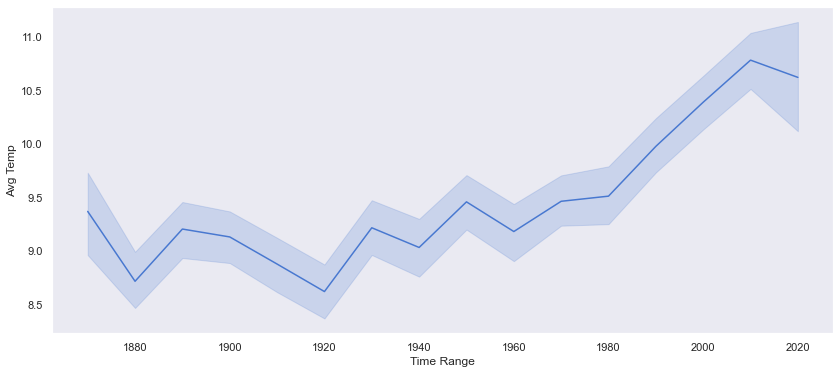

In [149]:
plot_data(berlin_temps)

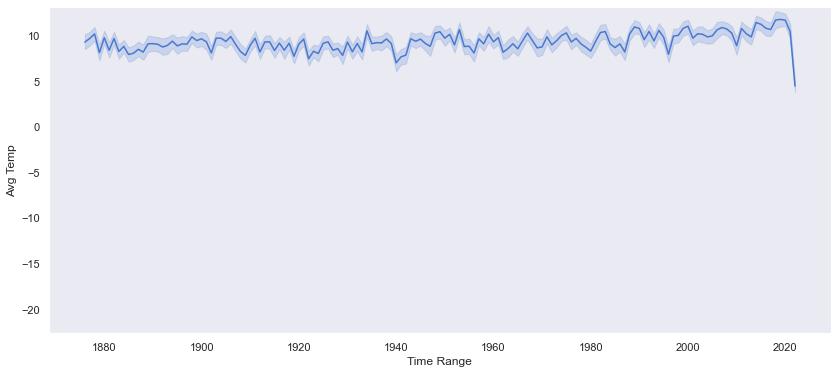

In [33]:
year = berlin_temps.index.year
plot_data(berlin_temps, year)

### Dataframe names
1. ```berlin_temps``` - no null values
2. ```berlin_temp_avg``` - groupby monthly average temps

In [34]:
berlin_temps['time_step'] = list(range(len(berlin_temps)))

### Time hang out with some models!

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.tsa.ar_model import AutoReg,ar_select_order

In [36]:
berlin_temps.columns

Index(['index', 'season', 'tg_clean', 'year_group', 'time_step'], dtype='object')

In [37]:
columns = ['time_step','tg_clean','season', 'year_group']
berlin_temps = berlin_temps.reindex(columns=columns)

### Create Month & Seasonal Mannequins

In [38]:
month_dummies= pd.get_dummies(berlin_temps.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(berlin_temps.index)

berlin_temps = berlin_temps.join(month_dummies)

In [39]:
seasonal_dummies= pd.get_dummies(berlin_temps.season,
                                  prefix='season',
                                  drop_first=True).set_index(berlin_temps.index)

berlin_temps = berlin_temps.join(seasonal_dummies)

In [40]:
day_dummies= pd.get_dummies(berlin_temps.index.day,
                                  prefix='day',
                                  drop_first=True).set_index(berlin_temps.index)

berlin_temps = berlin_temps.join(day_dummies)

In [41]:
berlin_temps.head()

,time_step,tg_clean,season,year_group,month_2,month_3,month_4,month_5,month_6,month_7,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
date,,,,,,,,,,,,,,,,,,,,,
1876-01-01,0,2.2,1,1870,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,2.5,1,1870,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-03,2,0.3,1,1870,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-04,3,-5.8,1,1870,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-05,4,-9.8,1,1870,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model the Seaon + Trend (Kylie Jenner)

In [42]:
len(berlin_temps.loc[:'1960-01-01'])

30661

In [43]:
def train_split(dataframe):
    
    #training data
    df_train = dataframe[30661:-365]
    
    df_test = dataframe[-365:]
     
    return df_train, df_test


In [44]:
def get_Xy(train_set, test_set):
    drop_columns = ['year_group', 'tg_clean', 'season']
     
    X_train = train_set.drop(columns=drop_columns)
    y_train = train_set['tg_clean']

    #test set
    X_test = test_set.drop(columns=drop_columns)
    y_test = test_set['tg_clean']
    return X_train, y_train, X_test, y_test

In [45]:
df_train, df_test = train_split(berlin_temps)

In [46]:
df_train

,time_step,tg_clean,season,year_group,month_2,month_3,month_4,month_5,month_6,month_7,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
date,,,,,,,,,,,,,,,,,,,,,
1960-01-02,30661,8.1,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1960-01-03,30662,5.4,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1960-01-04,30663,3.9,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1960-01-05,30664,6.0,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1960-01-06,30665,4.0,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24,52979,13.3,1,2020,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-02-25,52980,12.4,1,2020,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2021-02-26,52981,7.8,1,2020,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [47]:
X_train, y_train, X_test, y_test = get_Xy(df_train, df_test)

In [48]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22323, 45), (22323,), (365, 45), (365,))

### Get seasonality

In [49]:
m = LinearRegression()

In [50]:
m.fit(X_train,y_train)

LinearRegression()

In [51]:
df_train.loc[:,'trend_seasonal'] = m.predict(X_train)

C:\Users\emank\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Text(0.5, 1.0, 'Modelling trend and seasonality')

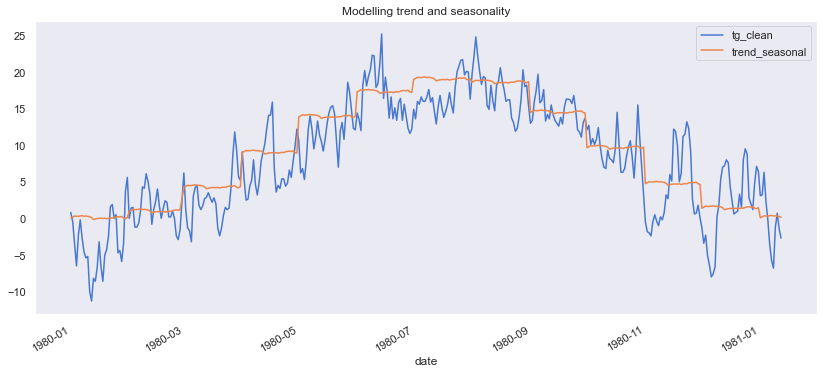

In [151]:
#sns.lineplot(data=df_train, x=df_train.index.year, y='trend')
df_train.loc['1980-01-01':'1981-01-12',['tg_clean','trend_seasonal']].plot()
plt.title('Modelling trend and seasonality')

### Get remainder

In [53]:
df_train['remainder'] = df_train['tg_clean']  - df_train['trend_seasonal']

C:\Users\emank\AppData\Local\Temp/ipykernel_11008/1454468889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['remainder'] = df_train['tg_clean']  - df_train['trend_seasonal']


In [54]:
df_train.head(2)

,time_step,tg_clean,season,year_group,month_2,month_3,month_4,month_5,month_6,month_7,...,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,,,,,,
1960-01-02,30661,8.1,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.505972,8.605972
1960-01-03,30662,5.4,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.364147,5.764147


Text(0.5, 1.0, 'Remainder after modelling trend and seasonality')

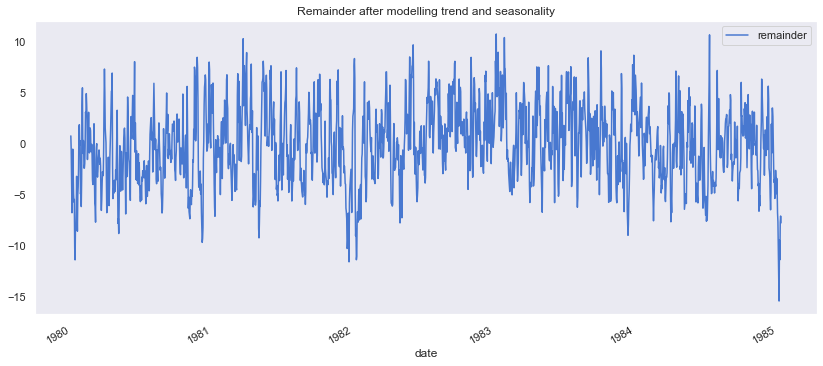

In [55]:
df_train.loc['1980-01-01':'1985-01-12',['remainder']].plot()
plt.title('Remainder after modelling trend and seasonality')

In [56]:
df_train["remainder"].std(), df_train["tg_clean"].std()

(3.9361724388352406, 7.891114478088452)

### Stationarity Checkpoint

In [57]:
def stationarity_check(remainder):
    """
    This is a function for checking the stationarity of our remainder.
    It returns a dataframe
    """
    from statsmodels.tsa import stattools
    adf_stats, p, used_lag, n_obs, levels, information_criterion \
    = stattools.adfuller(remainder)
    
    high = levels['1%']
    mid = levels['5%']
    low = levels['10%']
    
    adf_values = {'adf_stats': adf_stats, 
              'p':p, 'used_lag':used_lag,
              'n_obs':n_obs,
              '99% CI':high,
              '95% CI':mid,
              '90% CI':low,
              'information_criterion':information_criterion}
    
    return pd.DataFrame(data = adf_values, index=[0])

In [58]:
stationarity = stationarity_check(df_train["remainder"])

In [59]:
stationarity

,adf_stats,p,used_lag,n_obs,99% CI,95% CI,90% CI,information_criterion
0,-21.556999,0.0,31,22291,-3.430643,-2.86167,-2.566839,100474.919304


### Get lags

In [60]:
def get_lags(remainder, maxlag=12):
    """
    Reuseable fuction for getting number of lags"""

    selected_order = ar_select_order(remainder, maxlag = maxlag)
    return selected_order.ar_lags

In [61]:
def make_lags(dataframe, lags):
    """
    This function takes a dataframe and the number of lags needed
    then returns a dataframe with all the lag columns already added
    """
    for i in lags:
        dataframe[f'lag{i}'] = dataframe['remainder'].shift(i)
    dataframe.dropna(inplace=True)

In [62]:
lags = get_lags(df_train['remainder'])
make_lags(df_train, lags)

C:\Users\emank\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\emank\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\emank\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\emank\AppData\Local\Temp/ipykernel_11008/3800466101.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [63]:
df_train

,time_step,tg_clean,season,year_group,month_2,month_3,month_4,month_5,month_6,month_7,...,day_27,day_28,day_29,day_30,day_31,trend_seasonal,remainder,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,,,
1960-01-05,30664,6.0,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,-0.389896,6.389896,4.300386,5.764147,8.605972
1960-01-06,30665,4.0,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,-0.344392,4.344392,6.389896,4.300386,5.764147
1960-01-07,30666,3.5,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,-0.311831,3.811831,4.344392,6.389896,4.300386
1960-01-08,30667,0.9,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,-0.389487,1.289487,3.811831,4.344392,6.389896
1960-01-09,30668,-3.9,1,1960,0,0,0,0,0,0,...,0,0,0,0,0,-0.360059,-3.539941,1.289487,3.811831,4.344392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24,52979,13.3,1,2020,1,0,0,0,0,0,...,0,0,0,0,0,2.453777,10.846223,8.451672,4.228239,6.577013
2021-02-25,52980,12.4,1,2020,1,0,0,0,0,0,...,0,0,0,0,0,2.511952,9.888048,10.846223,8.451672,4.228239
2021-02-26,52981,7.8,1,2020,1,0,0,0,0,0,...,0,0,0,0,0,2.543423,5.256577,9.888048,10.846223,8.451672


In [64]:
drop_columns = ['year_group', 'tg_clean', 'season', 'trend_seasonal', 'remainder']

X_full = df_train.drop(columns=drop_columns)
y_full = df_train['tg_clean']

In [65]:
X_full.shape, y_full.shape

((22320, 48), (22320,))

In [66]:
m_full = LinearRegression()

In [67]:
m_full.fit(X_full, y_full)

LinearRegression()

In [71]:
df_train.loc[:,'predictions_full_model'] = m_full.predict(X_full)

C:\Users\emank\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [69]:
df_train.head()

,time_step,tg_clean,season,year_group,month_2,month_3,month_4,month_5,month_6,month_7,...,day_28,day_29,day_30,day_31,trend_seasonal,remainder,lag1,lag2,lag3,predications_full_model
date,,,,,,,,,,,,,,,,,,,,,
1960-01-05,30664,6.0,1,1960,0,0,0,0,0,0,...,0,0,0,0,-0.389896,6.389896,4.300386,5.764147,8.605972,3.066666
1960-01-06,30665,4.0,1,1960,0,0,0,0,0,0,...,0,0,0,0,-0.344392,4.344392,6.389896,4.300386,5.764147,5.146631
1960-01-07,30666,3.5,1,1960,0,0,0,0,0,0,...,0,0,0,0,-0.311831,3.811831,4.344392,6.389896,4.300386,2.735158
1960-01-08,30667,0.9,1,1960,0,0,0,0,0,0,...,0,0,0,0,-0.389487,1.289487,3.811831,4.344392,6.389896,2.745643
1960-01-09,30668,-3.9,1,1960,0,0,0,0,0,0,...,0,0,0,0,-0.360059,-3.539941,1.289487,3.811831,4.344392,0.393025


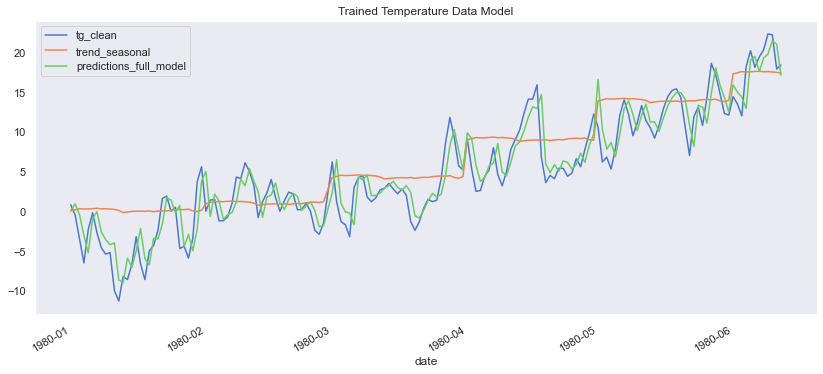

In [74]:
df_train.loc['1980-01-01':'1980-06-12',['tg_clean','trend_seasonal', 'predictions_full_model']].plot()
plt.title('Trained Temperature Data Model')
plt.show()

In [75]:
m_full.coef_

array([ 9.32373979e-05,  9.12896028e-01, -2.51392930e+00,  2.19880129e+00,
        7.03722454e+00,  3.54029188e+00,  5.28889159e+00,  4.80679141e+00,
        7.23254867e+00,  2.41067714e+00, -2.50619737e+00,  1.31431765e+00,
        6.72209653e+00,  1.36359749e+01,  7.13702844e+00,  1.31771349e-01,
        2.85771490e-01,  2.47861786e-01,  2.59238235e-01,  3.04649085e-01,
        3.37117155e-01,  2.59367242e-01,  2.88701797e-01,  2.40379677e-01,
        1.96962189e-01,  6.90760362e-02, -1.92733822e-01, -1.25252128e-01,
       -4.98685262e-02, -2.95257962e-02, -1.74936930e-02, -4.52436062e-02,
        3.57323815e-03, -9.27052853e-02, -2.00464791e-02,  2.86341254e-02,
        5.10764551e-03,  1.10463999e-01,  1.68545149e-01,  1.99923301e-01,
        1.55007175e-01,  2.36657807e-01,  9.67747757e-02, -8.28025912e-02,
       -1.21494818e-02,  9.28277695e-01, -2.08927181e-01,  7.42493551e-02])

In [76]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [77]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [   0    1    2 ... 3717 3718 3719]
The validation data for the 1th iteration are the observations steps
    [3720 3721 3722 ... 7437 7438 7439]


The training data for the 2th iteration are the observations steps 
    [   0    1    2 ... 7437 7438 7439]
The validation data for the 2th iteration are the observations steps
    [ 7440  7441  7442 ... 11157 11158 11159]


The training data for the 3th iteration are the observations steps 
    [    0     1     2 ... 11157 11158 11159]
The validation data for the 3th iteration are the observations steps
    [11160 11161 11162 ... 14877 14878 14879]


The training data for the 4th iteration are the observations steps 
    [    0     1     2 ... 14877 14878 14879]
The validation data for the 4th iteration are the observations steps
    [14880 14881 14882 ... 18597 18598 18599]


The training data for the 5th iteration are the observations steps 
    [    0     1     2 ...

In [78]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full)

In [79]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.9065124 , 0.90595544, 0.90751258, 0.92416216, 0.9193094 ])

In [80]:
result.mean()

0.9126903944734199

In [81]:
X_full

,time_step,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,day_25,day_26,day_27,day_28,day_29,day_30,day_31,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,,,
1960-01-05,30664,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.300386,5.764147,8.605972
1960-01-06,30665,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.389896,4.300386,5.764147
1960-01-07,30666,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.344392,6.389896,4.300386
1960-01-08,30667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.811831,4.344392,6.389896
1960-01-09,30668,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.289487,3.811831,4.344392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24,52979,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.451672,4.228239,6.577013
2021-02-25,52980,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,10.846223,8.451672,4.228239
2021-02-26,52981,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,9.888048,10.846223,8.451672


### Predict on test data

In [82]:
X_full.tail()

,time_step,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,day_25,day_26,day_27,day_28,day_29,day_30,day_31,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,,,
2021-02-24,52979,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.451672,4.228239,6.577013
2021-02-25,52980,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,10.846223,8.451672,4.228239
2021-02-26,52981,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,9.888048,10.846223,8.451672
2021-02-27,52982,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,5.256577,9.888048,10.846223
2021-02-28,52983,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2.501400,5.256577,9.888048


In [83]:
df_test['trend_seasonal'] = m.predict(X_test)

C:\Users\emank\AppData\Local\Temp/ipykernel_11008/1458445851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['trend_seasonal'] = m.predict(X_test)


In [84]:
df_test.head()

,time_step,tg_clean,season,year_group,month_2,month_3,month_4,month_5,month_6,month_7,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,trend_seasonal
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,52984,4.9,2,2020,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.639339
2021-03-02,52985,4.2,2,2020,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.775500
2021-03-03,52986,7.0,2,2020,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.917326
2021-03-04,52987,3.8,2,2020,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.881086
2021-03-05,52988,1.7,2,2020,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.891576


<AxesSubplot:xlabel='date'>

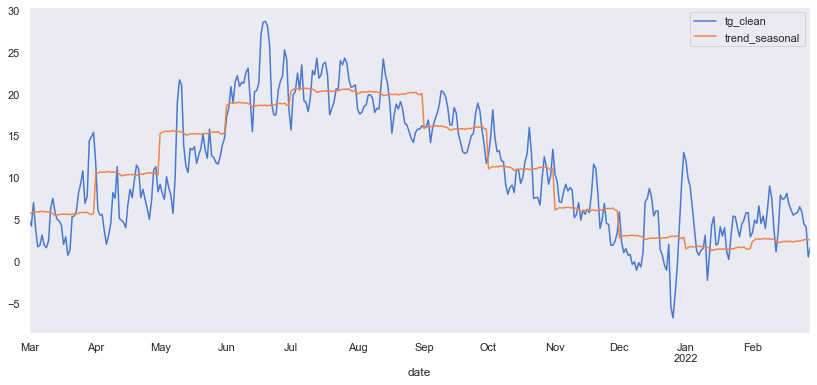

In [85]:
df_test[['tg_clean','trend_seasonal']].plot()

In [86]:
df_test['remainder'] = df_test['tg_clean'] - df_test['trend_seasonal']

C:\Users\emank\AppData\Local\Temp/ipykernel_11008/3347783277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['remainder'] = df_test['tg_clean'] - df_test['trend_seasonal']


<AxesSubplot:xlabel='date'>

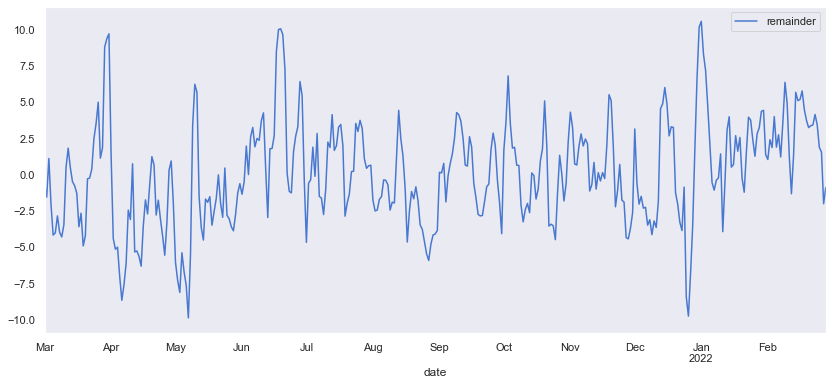

In [87]:
df_test[['remainder']].plot()

In [88]:
make_lags(df_test, lags)

C:\Users\emank\AppData\Local\Temp/ipykernel_11008/3800466101.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[f'lag{i}'] = dataframe['remainder'].shift(i)
C:\Users\emank\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [89]:
df_test

,time_step,tg_clean,season,year_group,month_2,month_3,month_4,month_5,month_6,month_7,...,day_27,day_28,day_29,day_30,day_31,trend_seasonal,remainder,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,,,
2021-03-04,52987,3.8,2,2020,0,1,0,0,0,0,...,0,0,0,0,0,5.881086,-2.081086,1.082674,-1.575500,-0.739339
2021-03-05,52988,1.7,2,2020,0,1,0,0,0,0,...,0,0,0,0,0,5.891576,-4.191576,-2.081086,1.082674,-1.575500
2021-03-06,52989,1.9,2,2020,0,1,0,0,0,0,...,0,0,0,0,0,5.937080,-4.037080,-4.191576,-2.081086,1.082674
2021-03-07,52990,3.1,2,2020,0,1,0,0,0,0,...,0,0,0,0,0,5.969642,-2.869642,-4.037080,-4.191576,-2.081086
2021-03-08,52991,1.9,2,2020,0,1,0,0,0,0,...,0,0,0,0,0,5.891985,-3.991985,-2.869642,-4.037080,-4.191576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,53344,5.9,1,2020,1,0,0,0,0,0,...,0,0,0,0,0,2.487777,3.412223,4.117672,3.394239,3.343013
2022-02-25,53345,4.4,1,2020,1,0,0,0,0,0,...,0,0,0,0,0,2.545952,1.854048,3.412223,4.117672,3.394239
2022-02-26,53346,4.1,1,2020,1,0,0,0,0,0,...,0,0,0,0,0,2.577423,1.522577,1.854048,3.412223,4.117672


In [90]:
drop_columns = ['year_group', 'tg_clean', 'season', 'trend_seasonal', 'remainder']

X_full = df_test.drop(columns=drop_columns)
y_full = df_test['tg_clean']

In [91]:
df_test['predictions_full_model'] = m_full.predict(X_full)

C:\Users\emank\AppData\Local\Temp/ipykernel_11008/1509820877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions_full_model'] = m_full.predict(X_full)


<AxesSubplot:xlabel='date'>

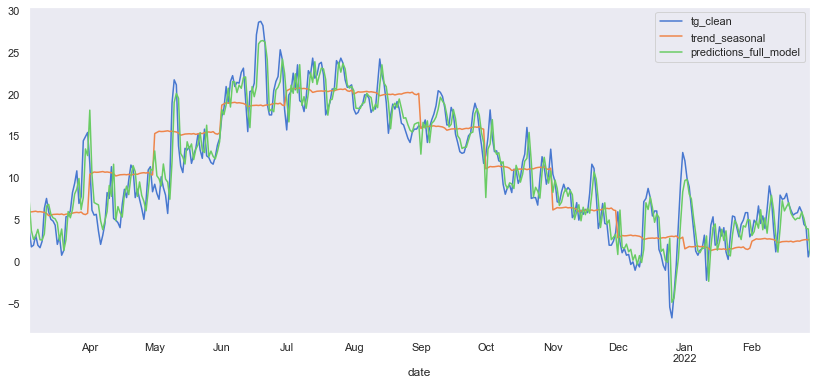

In [92]:
df_test[['tg_clean','trend_seasonal', 'predictions_full_model']].plot()

In [93]:
X_full

,time_step,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,day_25,day_26,day_27,day_28,day_29,day_30,day_31,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,,,
2021-03-04,52987,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.082674,-1.575500,-0.739339
2021-03-05,52988,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.081086,1.082674,-1.575500
2021-03-06,52989,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-4.191576,-2.081086,1.082674
2021-03-07,52990,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-4.037080,-4.191576,-2.081086
2021-03-08,52991,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.869642,-4.037080,-4.191576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,53344,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.117672,3.394239,3.343013
2022-02-25,53345,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,3.412223,4.117672,3.394239
2022-02-26,53346,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1.854048,3.412223,4.117672


In [95]:
full_temp = df_train[['tg_clean','trend_seasonal', 'predictions_full_model']].append(df_test[['tg_clean','trend_seasonal', 'predictions_full_model']])

<AxesSubplot:xlabel='date'>

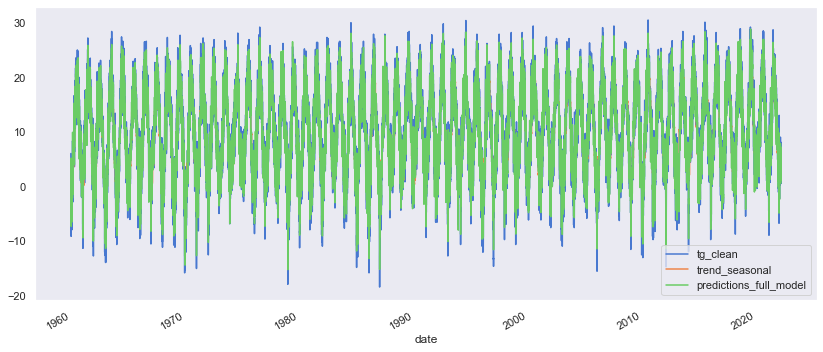

In [139]:
full_temp.plot()

In [104]:
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(endog= df_train['remainder'], lags = lags)
ar_model.fit()

C:\Users\emank\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [102]:
start = len(df_train)
stop = len(df_train) - 1

In [106]:
df_train['ar_prediction'] = ar_model.predict()

TypeError: predict() missing 1 required positional argument: 'params'

## Get q

In [107]:
from statsmodels.graphics.tsaplots import plot_acf

Text(0.5, 0, '# of lags')

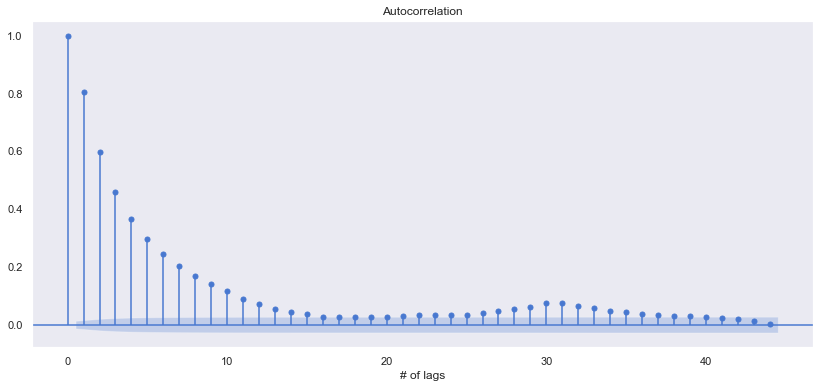

In [108]:
plot = plot_acf(df_train['remainder'])
plt.xlabel('# of lags')

## Get p

In [109]:
from statsmodels.graphics.tsaplots import plot_pacf

Text(0.5, 0, '# of lags')

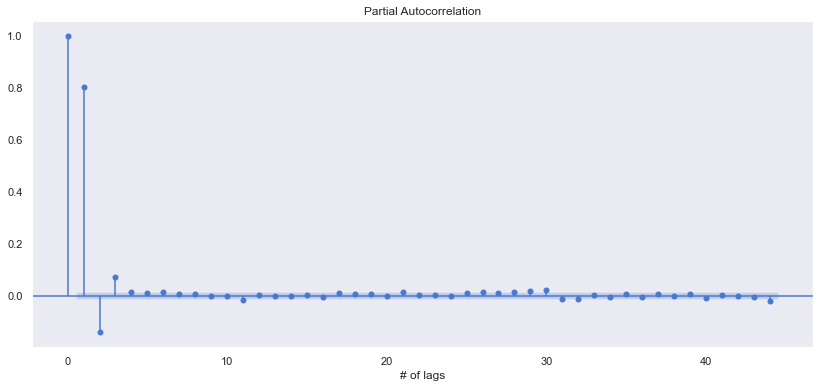

In [110]:
plot = plot_pacf(df_train['remainder'])
plt.xlabel('# of lags')

In [111]:
from statsmodels.tsa.arima_model import ARIMA

In [113]:
arima = ARIMA(df_train['remainder'], order = (1,0,6)).fit()

C:\Users\emank\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\emank\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

In [114]:
df_train['arima_prediction'] = arima.predict()

C:\Users\emank\AppData\Local\Temp/ipykernel_11008/2465012476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['arima_prediction'] = arima.predict()


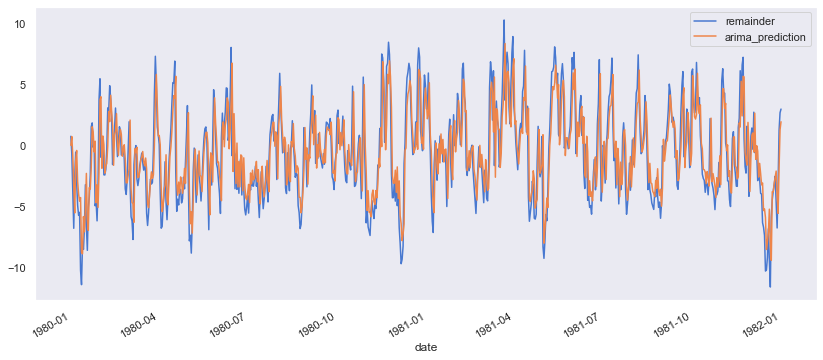

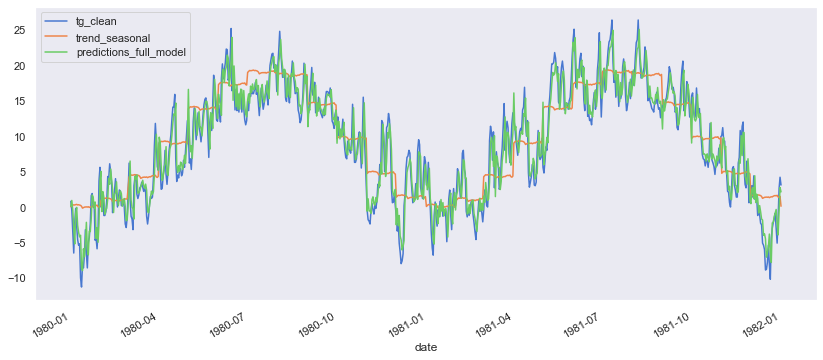

In [147]:
df_train.loc['1980-01-01':'1982-01-01',['remainder', 'arima_prediction']].plot()
full_temp.loc['1980-01-01':'1982-01-01'].plot()
plt.show()

In [122]:
from sklearn.metrics import mean_absolute_error

In [123]:
arima_error = round(mean_absolute_error(df_train['remainder'], df_train['arima_prediction']),2)

In [124]:
f'Mean absolute error for ARIMA: {arima_error}'

'Mean absolute error for ARIMA: 1.8'